In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import time
import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import misc
import cv2
import skimage.transform as trans
import numpy as np
import keras
import tensorflow as tf


from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.models import *
from keras.layers import *

from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau,EarlyStopping
from keras import backend as keras
from keras.utils import to_categorical

Using TensorFlow backend.


Prepare data

In [0]:
DATA_PATH = '/content/drive/My Drive/Diploma/Data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'Raw')
TRAIN_PATH = os.path.join(DATA_PATH, 'TrainImages')
TRAIN_MASKS_PATH = os.path.join(DATA_PATH, 'TrainMasks')
VALIDATION_PATH = os.path.join(DATA_PATH, 'ValidationImages')
VALIDATION_MASKS_PATH = os.path.join(DATA_PATH, 'ValidationMasks')
MODELS_PATH = '/content/drive/My Drive/Diploma/Data/Trained'
RAW_PATH = os.path.join(DATA_PATH, 'Raw')

# Constants
HEIGHT_ORIG = 966
WIDTH_ORIG = 1296
CHANNELS_ORIG = 3

SEED_VAL = 42

HEIGHT =256
WIDTH = 256
CHANNELS = 3
new_shape = (HEIGHT, WIDTH, CHANNELS)
mask_shape = (new_shape[0], new_shape[1], 1)

In [0]:
def get_img_id(img_path):
    return img_path[:len(img_path)-4]

#img_ids = list(map(get_img_id, list(train_masks_df.img.values)))

def load_image_disk(img_id, folder=TRAIN_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".png"))
    return img

def load_mask_disk(img_id, folder=TRAIN_MASKS_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".png"))
    return img 
  
# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".png"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def get_raw_img(img_id):
    return mpimg.imread(os.path.join(RAW_PATH, img_id + ".png")) 
    
def plot_image_from_array(img_array):
    imgplot = plt.imshow(img_array)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id):
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + ".png"))
    imgplot = plt.imshow(mask)
    plt.axis('off')
    plt.show()
    
def plot_masked_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".png"))
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + ".png"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1 
    masked_img = img * mask
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

#def get_img(img_id):
#    return mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".png"))
 
       
def get_mask(img_id, num_channels=-1):
    if num_channels!=-1:
        mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + ".png"), flatten=True)
        mask[mask > 128] = 1
        if len(mask.shape) == 2:
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        return mask
    else:
        mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + ".png"))
        mask = mask[:,:,0:3]
        return mask

def resize_img(img, new_s = new_shape):
    return trans.resize(img, new_s)

def load_imgs(img_id, folder=TRAIN_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".png"))
    return img

def gray2rgb(img):
    img = np.squeeze(img)
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret
  
  
  
def get_img_id(img_path):
    return img_path[:len(img_path)-4]
  
def load_image_disk(img_id, folder=TRAIN_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".png"))
    return img

def load_mask_disk(img_id, folder=TRAIN_MASKS_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".png"))
    return img 

In [0]:
# Read training images into memory
from tqdm import tqdm

train_imgs = {}
for img_path in tqdm(os.listdir(TRAIN_PATH)):
    img_id = get_img_id(img_path)
    train_imgs[img_id] = cv2.resize(load_image_disk(img_id), (new_shape[0], new_shape[1]))
    
    
# Read training masks into memory
train_masks = {}
for img_path in tqdm(os.listdir(TRAIN_MASKS_PATH)):
    img_id = get_img_id(img_path)
    train_masks[img_id] = cv2.resize(load_mask_disk(img_id), (new_shape[0], new_shape[1]))
    
    
validation_imgs = {}
for img_path in tqdm(os.listdir(VALIDATION_PATH)):
    img_id = get_img_id(img_path)
    validation_imgs[img_id] = cv2.resize(load_image_disk(img_id,VALIDATION_PATH), (new_shape[0], new_shape[1]))
    
validation_masks = {}
for img_path in tqdm(os.listdir(VALIDATION_MASKS_PATH)):
    img_id = get_img_id(img_path)
    validation_masks[img_id] = cv2.resize(load_mask_disk(img_id,VALIDATION_MASKS_PATH), (new_shape[0], new_shape[1]))

  0%|          | 0/239 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  0%|          | 0/239 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
100%|██████████| 44/44 [00:12<00:00,  3.79it/s]


In [0]:
def get_train_image(img_id):
    return train_imgs[img_id]
  
  
def get_train_mask(img_id):
    return train_masks[img_id]  
  
def get_validation_image(img_id):
    return validation_imgs[img_id]
  
  
def get_validation_mask(img_id):
    return validation_masks[img_id]

In [0]:
print(len(train_imgs))

239


In [0]:

train_imgs_list = list(train_imgs.values())
train_masks_list = list( train_masks.values())
validation_imgs_list = list(validation_imgs.values())
validation_masks_list = list(validation_masks.values())

#print(train_imgs_list.shape)
#print(train_masks_list.shape)
#print(validation_imgs_list.shape)
#print(validation_masks_list.shape)


train_ids = list(train_imgs.keys())
validation_ids= list(validation_imgs.keys())


print(train_ids)
print(validation_ids)

['113', '144', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '

In [0]:
def mask_convert256_to1(img, ):
  #print(f'input image{img.shape}')
  for i in range(len(img)):
    for j in range(len(img[i])):
      #print(img[i,j])
      if img[i,j][0] > 0.: 
        #print(img[i,j])
        img[i,j] = [1,0,0]
      else :
        img[i,j] = [0,0,0]
      

  return img[:,:,0]


def mask_convert256_to1A(img, ):
  arr = np.zeros((256,256,1))
  for i in range(len(img)):
    for j in range(len(img[i])):
      #print(img[i,j])
      if img[i,j][2] > 0.: 
        #print(img[i,j])
        arr[i,j] = [1]
      
      #for z in range(len(img[i,j])):
        #print(z)
        #if img[i,j,0] == 255:
            #img[i,j,0] = 1
            #print(replaced)
  return arr

def arr_convertA_to_mask(img ):
  print(f'inpyut: {img.shape}')
  arr = np.zeros((256,256,3))
  for i in range(len(img)):
    for j in range(len(img[i])):
      arr[i,j][0] = img[i,j][0]

  return arr



def arr_convertA_to_binary_mask(img ,threshold):
  print(f'inpyut: {img.shape}')
  arr = np.zeros((256,256,3))
  for i in range(len(img)):
    for j in range(len(img[i])):
      if img[i,j][0] > threshold:        
        arr[i,j][0] = 1
      

  return arr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


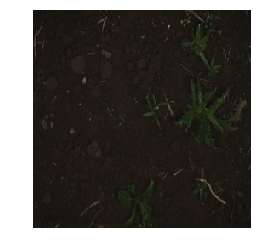

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


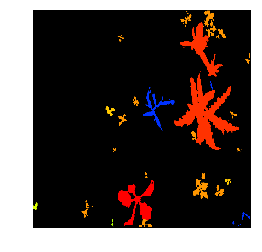

(256, 256, 1)
inpyut: (256, 256, 1)


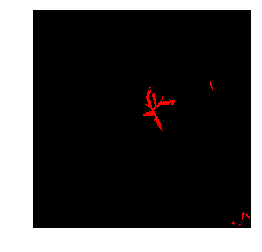

In [0]:
id = str(205)
raw = load_image_disk(id)
raw_s=resize_img(raw,new_shape)
#plot_image_from_array(raw)


raw_a =np.asarray(raw_s, dtype=np.float32)
plot_image_from_array(raw_a)

mask = load_mask_disk(id)
mask_s=resize_img(mask,new_shape)
plot_image_from_array(np.asarray(mask_s, dtype=np.float32))

new_mask =  mask_convert256_to1A(mask_s)
print(new_mask.shape)
plot_image_from_array(arr_convertA_to_mask(new_mask))



New form https://github.com/malhotraa/carvana-image-masking-challenge/blob/master/notebooks/model.py

In [0]:
def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_REFLECT_101, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(0, 0, 0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(0, 0, 0,))
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=2)

    return image, mask

In [0]:
def generate_training_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        
        for idx, img_id in enumerate(batch_ids):
            x = get_train_image(img_id)
            y = get_train_mask(img_id)
            x, y = randomShiftScaleRotate(x, y,
                                          shift_limit=(-0.0625, 0.0625),
                                          scale_limit=(-0.1, 0.1),
                                          rotate_limit=(-0, 0))

            
            
            y = mask_convert256_to1A(y)
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)/255
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y

def generate_validation_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        #print( batch_ids.shape)
        for idx, img_id in enumerate(batch_ids):
            x = get_validation_image(img_id)
            y = get_validation_mask(img_id)
            #print(idx)
            y = mask_convert256_to1A(y)
            X_batch.append(x)
            Y_batch.append(y)
        #print(f'bathc shape {len(Y_batch)}')
        X = np.asarray(X_batch, dtype=np.float32)/255
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y

In [0]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')



from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import time
t_start = time.time()

In [0]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [0]:
# Build Model
def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 50 -> 25
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 12 -> 6
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons*16)
    convm = residual_block(convm, start_neurons*16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='same')(uconv4)
    print(f"deconv3 {deconv3.shape} - {start_neurons*4}")
    print(f"conv3 {conv3.shape}")
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [0]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [0]:
# model

input_layer = Input(new_shape)
output_layer = build_model(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.005)
#model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
model1.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
#model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
deconv3 (?, ?, ?, 64) - 64
conv3 (?, 64, 64, 64)


In [0]:
import matplotlib.pyplot as plt
def printHistory2(history,run_name=None):
  #https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
  plt.plot(history.history['my_iou_metric_2'])
  plt.plot(history.history['val_my_iou_metric_2'])
  plt.title('model accuracy')
  plt.ylabel('val_my_iou_metric_2')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
# summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  
  if not run_name is None:
    fig1 = plt.gcf()
    plt.draw()
    fig1.savefig(os.path.join(pathForSave,run_name+'.png'), dpi=100)

In [0]:
checkpoint_loc = os.path.join(MODELS_PATH, 'kernel_sigmoid_2702_batch16_weed-{}-weights.h5'.format(time.time()))

early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min',patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(checkpoint_loc, monitor='val_loss', mode='min',
                                   save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', mode='min', factor=0.5, patience=5,
                              min_lr=0.0001, verbose=1)

epochs = 100
batch_size = 16
steps_per_epoch = 80

train_generator = generate_training_batch(train_ids, batch_size)
valid_generator = generate_validation_batch(validation_ids, batch_size)
VALIDATION_STEPS = int(len(validation_ids) / batch_size)


t_model1_start = time.time()
history = model1.fit_generator(
                      train_generator,
                      validation_data = valid_generator, 
                      epochs = epochs,
                      steps_per_epoch = steps_per_epoch,
                      validation_steps = VALIDATION_STEPS, 
                      callbacks = [early_stopping, model_checkpoint, reduce_lr],
                      verbose = 2)

t_model1_end = time.time()

print(f"Run time = {(t_model1_end-t_model1_start)/3600} hours")

Epoch 1/100
 - 184s - loss: 0.1688 - acc: 0.9790 - val_loss: 0.3857 - val_acc: 0.9712

Epoch 00001: val_loss improved from inf to 0.38571, saving model to /content/drive/My Drive/Diploma/Data/Trained/kernel_sigmoid_2702_batch16_weed-1556797625.7286613-weights.h5
Epoch 2/100
 - 161s - loss: 0.1496 - acc: 0.9798 - val_loss: 0.1988 - val_acc: 0.9753

Epoch 00002: val_loss improved from 0.38571 to 0.19884, saving model to /content/drive/My Drive/Diploma/Data/Trained/kernel_sigmoid_2702_batch16_weed-1556797625.7286613-weights.h5
Epoch 3/100
 - 160s - loss: 0.1370 - acc: 0.9806 - val_loss: 0.1678 - val_acc: 0.9718

Epoch 00003: val_loss improved from 0.19884 to 0.16776, saving model to /content/drive/My Drive/Diploma/Data/Trained/kernel_sigmoid_2702_batch16_weed-1556797625.7286613-weights.h5
Epoch 4/100
 - 162s - loss: 0.1272 - acc: 0.9824 - val_loss: 0.1802 - val_acc: 0.9656

Epoch 00004: val_loss did not improve from 0.16776
Epoch 5/100
 - 164s - loss: 0.1205 - acc: 0.9829 - val_loss: 0.14

KeyboardInterrupt: ignored

In [0]:
printHistory2(history)

NameError: ignored

In [0]:
model1 = load_model(checkpoint_loc, custom_objects={'my_iou_metric':my_iou_metric})
# remove activation layer and use lovasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.01)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

In [0]:
checkpoint_loc2 = os.path.join(MODELS_PATH, 'kernel2_sigmoid_2702_batch16_weed-{}-weights.h5'.format(time.time()))

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=30, verbose=1)
model_checkpoint = ModelCheckpoint(checkpoint_loc2,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, 
                              min_lr=0.00005, verbose=1)
epochs = 120
batch_size = 4

t_model2_start = time.time()
history = model.fit_generator(
                      train_generator,
                      validation_data = valid_generator, 
                      epochs = epochs,
                      steps_per_epoch = steps_per_epoch,
                      validation_steps = VALIDATION_STEPS, 
                      callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                      verbose=2)
t_model2_end = time.time()
print(f"Run time = {(t_model2_end-t_model2_start)/3600} hours")

In [0]:
model1.save(os.path.join(MODELS_PATH, 'kernel2_sigmoid_weights.h5'))

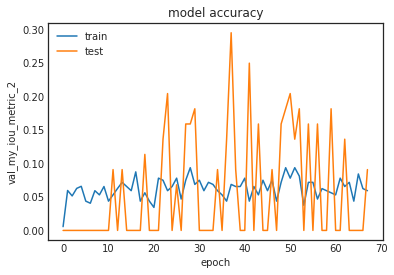

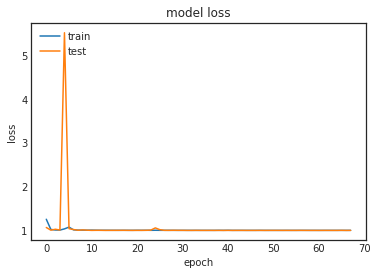

In [0]:
printHistory2(history)

In [0]:
from keras.models import load_model
img_ids = train_ids + validation_ids

BATCH_SIZE = 6

# Training new model
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 50
steps_per_epoch = 80
run_name = 'modelNew={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)

checkpoint_loc = os.path.join(MODELS_PATH, 'new_sigmoid_2702_batch16_weed-{}-weights.h5'.format(time.time()))



modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = False)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

callbacks_list = [modelCheckpoint,early_stop]

model = unet_sigmoid('/content/drive/My Drive/Diploma/Data/Trained/new_sigmoid_2702_batch16_weed-1555935656.9094074-weights.h5')
#model = Unet('resnet34', classes=1, activation='sigmoid')
#model = keras.models.load_model(MODELS_PATH+'/model-1550600504-weights.h5')
#model.compile(optimizer = Adam(lr = 1e-4),loss=bce_jaccard_loss, metrics = ['accuracy'])


#print(model.summary())
#get_model_memory_usage(BATCH_SIZE, model)

#model = unet_sigmoid()
#model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])



train_generator = generate_training_batch(train_ids, BATCH_SIZE)
valid_generator = generate_validation_batch(validation_ids, BATCH_SIZE)
VALIDATION_STEPS = int(len(validation_ids) / BATCH_SIZE)

print(VALIDATION_STEPS)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Weight loaded
7


(16, 256, 256, 3)
(256, 256, 3)


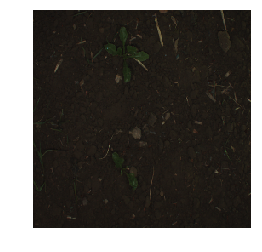

inpyut: (256, 256, 1)


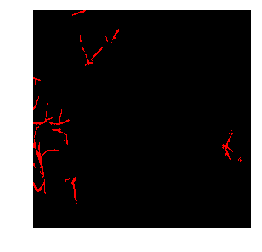

In [0]:
(x_from_generator,y_from_generator) = next(valid_generator)
print(x_from_generator.shape)
print(x_from_generator[2,:,:,:].shape)
plot_image_from_array(x_from_generator[0,:,:,:])
#print(x_from_generator[0,:,:,:]/255)
plot_image_from_array(arr_convertA_to_mask(y_from_generator[0,:,:,:]))

> >>>>>>>Train model

Starting run modelNew=malhot-batch_size=6-num_epoch=50-steps_per_epoch=80-ts=1555937840
Epoch 1/50
80/80 [==============================] - 84s 1s/step - loss: 0.0482 - acc: 0.9838 - val_loss: 0.0468 - val_acc: 0.9846

Epoch 00001: val_loss improved from inf to 0.04679, saving model to /content/drive/My Drive/Diploma/Data/Trained/new_sigmoid_2702_batch16_weed-1555937840.1672425-weights.h5
Epoch 2/50
80/80 [==============================] - 77s 956ms/step - loss: 0.0332 - acc: 0.9874 - val_loss: 0.0822 - val_acc: 0.9764

Epoch 00002: val_loss did not improve from 0.04679


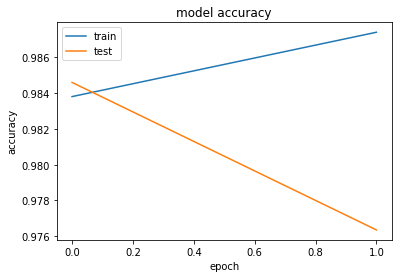

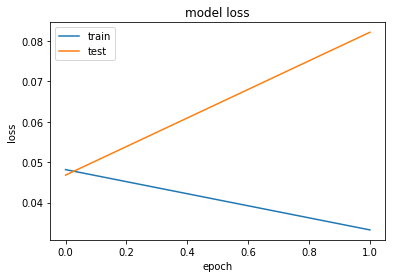

In [0]:
print('Starting run {}'.format(run_name))
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = VALIDATION_STEPS)

printHistory2(history)

In [0]:
model_path = os.path.join(MODELS_PATH, 'CropSigmoid_WorkModel-{}.h5'.format(ts))
history_path = os.path.join(MODELS_PATH, 'model50-{}.history'.format(ts))
model.save(model_path)
print('Saved model at {}'.format(model_path))
print('Saved model history at {}'.format(history_path))

In [0]:
Results


In [0]:
#input_layer = Input(new_shape)
#output_layer = build_model(input_layer, 16,0.5)

#model = Model(input_layer, output_layer)

#c = optimizers.adam(lr = 0.005)
#model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
model = model1
model.load_weights(os.path.join(MODELS_PATH,'kernel_sigmoid_2702_batch16_weed-1556797625.7286613-weights.h5'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(256, 256, 3)
<class 'numpy.ndarray'>


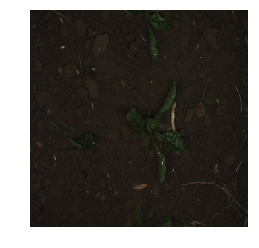

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


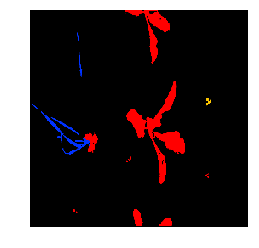

In [0]:
id = str(19)
raw = load_image_disk(id)
raw_s=resize_img(raw,new_shape)
#plot_image_from_array(raw)

z = np.zeros(new_shape)

X_batch = []
#X_batch.append(z)
X_batch.append(raw_s)
X = np.asarray(X_batch, dtype=np.float32)
print(X[0,:,:,:].shape)
print(type(X))

plot_image_from_array(X[0,:,:,:])

mask = load_mask_disk(id)
mask_s=resize_img(mask,new_shape)
plot_image_from_array(np.asarray(mask_s, dtype=np.float32))

inpyut: (256, 256, 1)


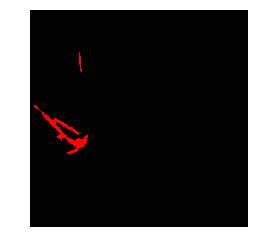

In [0]:


#plot_image_from_array(X[0,:,:,:])
result = model.predict(X)

#print(result)
result_2 =arr_convertA_to_binary_mask(result[0,:,:,:],0.40)
plot_image_from_array(result_2)



In [0]:
# evaluate the model
(x_from_generator,y_from_generator) = next(valid_generator)
scores = model.evaluate(x_from_generator,y_from_generator)
print("%s: %.2f%%" % (model.metrics_names[0], scores[1]*100))

16/16 [==============================] - 1s 44ms/step
loss: 96.75%
